In [76]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import lightgbm as lgb
import matplotlib.pyplot as plt

In [62]:
def rename_columns_for_merge(df: pd.DataFrame) -> pd.DataFrame:
    """
    Renames the 'userid' column to 'user_id' in a DataFrame
    to ensure consistent merging.
    This function is idempotent, meaning it can be run multiple times
    without causing errors if the column is already renamed.
    """
    if 'userid' in df.columns:
        df = df.rename(columns={'userid': 'user_id'})
    return df

In [63]:
RAW_SAMPLE_PATH = 'data/raw_sample.csv'
AD_FEATURE_PATH = 'data/ad_feature.csv'
USER_PROFILE_PATH = 'data/user_profile.csv'

if not os.path.exists(RAW_SAMPLE_PATH):
    print(f"Error: {RAW_SAMPLE_PATH} not found. Please ensure the data files are in the correct directory.")
    exit()
if not os.path.exists(AD_FEATURE_PATH):
    print(f"Error: {AD_FEATURE_PATH} not found. Please ensure the data files are in the correct directory.")
    exit()
if not os.path.exists(USER_PROFILE_PATH):
    print(f"Error: {USER_PROFILE_PATH} not found. Please ensure the data files are in the correct directory.")
    exit()

try:
    df_raw_sample = pd.read_csv(RAW_SAMPLE_PATH)
    df_ad_feature = pd.read_csv(AD_FEATURE_PATH)
    df_user_profile = pd.read_csv(USER_PROFILE_PATH)
except Exception as e:
    print(f"Error loading datasets: {e}")
    exit()

In [64]:
# Transform 'nonclk' to 'click' column
df_raw_sample['click'] = 1 - df_raw_sample['nonclk']
df_raw_sample = df_raw_sample.drop('nonclk', axis=1)

In [65]:
# Fill missing values in ad_feature with -1 for numerical IDs and 'unknown' for others
for col in ['category_id', 'campaign_id', 'brand', 'customer_id']:
    if col in df_ad_feature.columns:
        if pd.api.types.is_numeric_dtype(df_ad_feature[col]):
            df_ad_feature[col] = df_ad_feature[col].fillna(-1).astype(int)
        else:
            df_ad_feature[col] = df_ad_feature[col].fillna('unknown')

In [66]:
# Fill missing values in user_profile with -1 for numerical IDs and 'unknown' for others
for col in df_user_profile.columns:
    if pd.api.types.is_numeric_dtype(df_user_profile[col]):
        df_user_profile[col] = df_user_profile[col].fillna(-1).astype(int)
    else:
        df_user_profile[col] = df_user_profile[col].fillna('unknown')

In [67]:
# Apply renaming for df_raw_sample and df_user_profile to ensure consistent 'user_id' for merging.

# Explicitly handle potential user ID column name variations in raw_sample
if 'user' in df_raw_sample.columns:
    df_raw_sample = df_raw_sample.rename(columns={'user': 'user_id'})
elif 'user_id' not in df_raw_sample.columns:
    # Fallback for other common variations if 'user' isn't found
    if 'userid' in df_raw_sample.columns:
        df_raw_sample = df_raw_sample.rename(columns={'userid': 'user_id'})
    elif 'User_ID' in df_raw_sample.columns:
        df_raw_sample = df_raw_sample.rename(columns={'User_ID': 'user_id'})
    elif 'userID' in df_raw_sample.columns:
        df_raw_sample = df_raw_sample.rename(columns={'userID': 'user_id'})
    else:
        print("Warning: Neither 'user', 'user_id', 'userid', 'User_ID', nor 'userID' column found in raw_sample.csv. This might lead to merge issues.")

# Apply the general renaming function for user_profile (and potentially raw_sample if 'userid' was present)
df_user_profile = rename_columns_for_merge(df_user_profile)

In [68]:
# Merge raw_sample with ad_feature on 'adgroup_id'
df_merged = pd.merge(df_raw_sample, df_ad_feature, on='adgroup_id', how='left')

In [69]:
# Merge the result with user_profile on user_id (from raw_sample) and user_id (from user_profile)
df_final = pd.merge(df_merged, df_user_profile, on='user_id', how='left')

In [70]:
df_final.info()
print(df_final.head())
print(df_final.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26557961 entries, 0 to 26557960
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   user_id                int64  
 1   time_stamp             int64  
 2   adgroup_id             int64  
 3   pid                    object 
 4   clk                    int64  
 5   click                  int64  
 6   cate_id                int64  
 7   campaign_id            int64  
 8   customer               int64  
 9   brand                  int64  
 10  price                  float64
 11  cms_segid              float64
 12  cms_group_id           float64
 13  final_gender_code      float64
 14  age_level              float64
 15  pvalue_level           float64
 16  shopping_level         float64
 17  occupation             float64
 18  new_user_class_level   float64
dtypes: float64(9), int64(9), object(1)
memory usage: 3.8+ GB
   user_id  time_stamp  adgroup_id          pid  clk  click  cate_i

In [71]:
# Convert time_stamp to datetime objects
df_final['time_stamp'] = pd.to_datetime(df_final['time_stamp'], unit='s')

# Extract time-based features
df_final['hour'] = df_final['time_stamp'].dt.hour
df_final['dayofweek'] = df_final['time_stamp'].dt.dayofweek
df_final['dayofyear'] = df_final['time_stamp'].dt.dayofyear

# Optional: Drop the original time_stamp column to reduce memory usage
df_final = df_final.drop('time_stamp', axis=1)

print("Time-based features created successfully.")
print(df_final[['hour', 'dayofweek', 'dayofyear']].head())
print(df_final.info())

Time-based features created successfully.
   hour  dayofweek  dayofyear
0     6          6        127
1     1          5        133
2     4          5        133
3     4          5        133
4     4          1        129
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26557961 entries, 0 to 26557960
Data columns (total 21 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   user_id                int64  
 1   adgroup_id             int64  
 2   pid                    object 
 3   clk                    int64  
 4   click                  int64  
 5   cate_id                int64  
 6   campaign_id            int64  
 7   customer               int64  
 8   brand                  int64  
 9   price                  float64
 10  cms_segid              float64
 11  cms_group_id           float64
 12  final_gender_code      float64
 13  age_level              float64
 14  pvalue_level           float64
 15  shopping_level         float64
 16  occupation

In [72]:
# Create a combined key for user-ad interactions
df_final['user_ad_key'] = df_final['user_id'].astype(str) + '_' + df_final['adgroup_id'].astype(str)

# Calculate historical impression counts for each adgroup_id
df_final['ad_impressions_count'] = df_final.groupby('adgroup_id')['adgroup_id'].transform('count')

# Calculate historical click counts for each adgroup_id
df_final['ad_clicks_count'] = df_final.groupby('adgroup_id')['click'].transform('sum')

# Calculate the historical Click-Through Rate (CTR) for each adgroup_id
# Use a small constant to prevent division by zero for ads with 0 impressions.
df_final['ad_ctr'] = df_final['ad_clicks_count'] / (df_final['ad_impressions_count'] + 1e-6)


# Calculate the count of distinct categories visited by each user
df_final['user_distinct_categories'] = df_final.groupby('user_id')['cate_id'].transform('nunique')

# Calculate the number of times a user has interacted with a specific category
df_final['user_category_interactions'] = df_final.groupby(['user_id', 'cate_id'])['cate_id'].transform('count')

# Display the new features
print("Count and behavioral features created successfully.")
print(df_final[['user_id', 'adgroup_id', 'ad_impressions_count', 'ad_clicks_count', 'ad_ctr', 'user_distinct_categories', 'user_category_interactions']].head())
print("\nFinal DataFrame Info with new features:")
df_final.info()

Count and behavioral features created successfully.
   user_id  adgroup_id  ad_impressions_count  ad_clicks_count  ad_ctr  \
0   581738           1                     1                0     0.0   
1   449818           3                     1                0     0.0   
2   914836           4                     1                0     0.0   
3   914836           5                     1                0     0.0   
4   399907           8                     1                0     0.0   

   user_distinct_categories  user_category_interactions  
0                        38                           1  
1                         3                           1  
2                         4                          25  
3                         4                          25  
4                        11                           1  

Final DataFrame Info with new features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26557961 entries, 0 to 26557960
Data columns (total 27 columns):
 #   

In [73]:
# Ensure df_final is a pandas DataFrame and exists from previous steps.

# Training data: 2017-05-06 to 2017-05-12
# Test data: 2017-05-13
print("Splitting data into training and test sets based on time_stamp...")

try:
    df_train = df_final[(df_final['dayofyear'] >= 126) & (df_final['dayofyear'] <= 132)]
    df_test = df_final[df_final['dayofyear'] == 133]
except KeyError:
    print("Warning: `dayofyear` column not found. Re-creating for temporal split.")
    df_final['time_stamp'] = pd.to_datetime(df_final['time_stamp'], unit='s')
    df_final['dayofyear'] = df_final['time_stamp'].dt.dayofyear
    df_train = df_final[(df_final['dayofyear'] >= 126) & (df_final['dayofyear'] <= 132)]
    df_test = df_final[df_final['dayofyear'] == 133]


# Define features and target
feature_cols = ['hour', 'dayofweek', 'ad_impressions_count', 'ad_clicks_count', 'ad_ctr', 'user_distinct_categories', 'user_category_interactions']
target_col = 'click'

X_train = df_train[feature_cols]
y_train = df_train[target_col]
X_test = df_test[feature_cols]
y_test = df_test[target_col]

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")


print("\nTraining Logistic Regression baseline model...")

# Create the model
lr_model = LogisticRegression(solver='liblinear', random_state=42)

# Train the model on the training data
lr_model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

print("\nEvaluating baseline model on the test set...")

# Get predictions for the test set
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC
auc_score = roc_auc_score(y_test, y_pred_proba)

# Calculate Log Loss
logloss_score = log_loss(y_test, y_pred_proba)

print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Log Loss Score: {logloss_score:.4f}")

print("\nMilestone 2: Data Splitting and Baseline Model Training Completed.")

Splitting data into training and test sets based on time_stamp...
Training set shape: (23266013, 7), Test set shape: (2848505, 7)

Training Logistic Regression baseline model...
Logistic Regression model trained successfully.

Evaluating baseline model on the test set...
AUC-ROC Score: 0.6802
Log Loss Score: 0.1918

Milestone 2: Data Splitting and Baseline Model Training Completed.


Training LightGBM model...
[LightGBM] [Info] Number of positive: 1200043, number of negative: 22065970
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1158
[LightGBM] [Info] Number of data points in the train set: 23266013, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.051579 -> initscore=-2.911679
[LightGBM] [Info] Start training from score -2.911679
LightGBM model trained successfully.

Evaluating LightGBM model on the test set...
LightGBM AUC-ROC Score: 0.6935
LightGBM Log Loss Score: 0.1853

Visualizing feature importance...


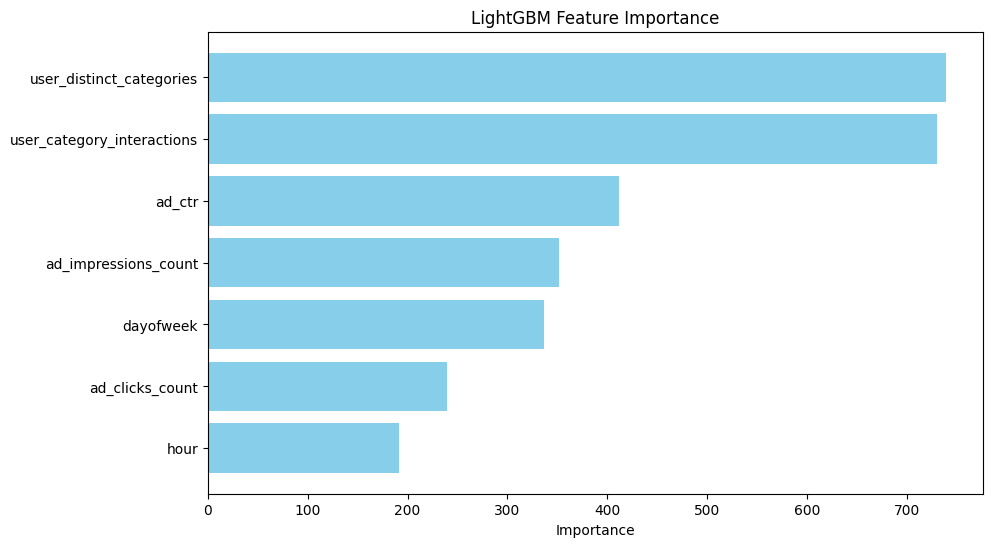


Milestone 3: Gradient Boosting Model Training and Evaluation Completed.


In [74]:
# Define features and target
feature_cols = ['hour', 'dayofweek', 'ad_impressions_count', 'ad_clicks_count', 'ad_ctr', 'user_distinct_categories', 'user_category_interactions']
target_col = 'click'

print("Training LightGBM model...")

# Instantiate the LightGBM classifier
lgb_model = lgb.LGBMClassifier(objective='binary', random_state=42)

# Train the model on the training data
lgb_model.fit(X_train, y_train)

print("LightGBM model trained successfully.")

print("\nEvaluating LightGBM model on the test set...")

# Get predictions for the test set
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC
auc_score_lgb = roc_auc_score(y_test, y_pred_proba_lgb)

# Calculate Log Loss
logloss_score_lgb = log_loss(y_test, y_pred_proba_lgb)

print(f"LightGBM AUC-ROC Score: {auc_score_lgb:.4f}")
print(f"LightGBM Log Loss Score: {logloss_score_lgb:.4f}")

print("\nVisualizing feature importance...")

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('LightGBM Feature Importance')
plt.gca().invert_yaxis()
plt.show()

print("\nMilestone 3: Gradient Boosting Model Training and Evaluation Completed.")

In [75]:
# A quick check to make sure the DataFrame is available.
if 'df_final' not in locals():
    print("Error: df_final is not available. Please run the previous milestone steps first.")
    # Exit or load data from a saved file for robustness
    # df_final = pd.read_csv('final_data.csv')

print("Starting Milestone 4: Advanced Feature Engineering...")

# Interaction Features
df_final['user_age_ad_category'] = df_final['age_level'].astype(str) + '_' + df_final['cate_id'].astype(str)
df_final['user_shopping_ad_category'] = df_final['shopping_level'].astype(str) + '_' + df_final['cate_id'].astype(str)
df_final['user_gender_ad_category'] = df_final['final_gender_code'].astype(str) + '_' + df_final['cate_id'].astype(str)
df_final['ad_category_campaign'] = df_final['cate_id'].astype(str) + '_' + df_final['campaign_id'].astype(str)

# Behavioral Features
df_final['user_ad_impressions'] = df_final.groupby(['user_id', 'adgroup_id'])['adgroup_id'].transform('count')

# Encoding Categorical Features
categorical_features = [
    'pid', 'cate_id', 'campaign_id', 'customer', 'brand',
    'cms_segid', 'cms_group_id', 'final_gender_code', 'age_level',
    'pvalue_level', 'shopping_level', 'occupation',
    'user_age_ad_category', 'user_shopping_ad_category',
    'user_gender_ad_category', 'ad_category_campaign'
]

# Convert columns to 'category' dtype for LightGBM's native handling
for col in categorical_features:
    df_final[col] = df_final[col].astype('category')

print("Advanced features and categorical encoding applied successfully.")
print(df_final.info())

df_train = df_final[df_final['dayofyear'] < 133]
df_test = df_final[df_final['dayofyear'] == 133]

# Define new feature list
new_feature_cols = [
    'hour', 'dayofweek', 'ad_impressions_count', 'ad_clicks_count', 'ad_ctr',
    'user_distinct_categories', 'user_category_interactions',
    'user_age_ad_category', 'user_shopping_ad_category',
    'user_gender_ad_category', 'ad_category_campaign',
    'cate_id', 'campaign_id', 'brand', 'customer', 'pid',
    'cms_segid', 'cms_group_id', 'final_gender_code', 'age_level',
    'pvalue_level', 'shopping_level', 'occupation'
]

X_train = df_train[new_feature_cols]
y_train = df_train['click']
X_test = df_test[new_feature_cols]
y_test = df_test['click']

print(f"\nTraining set shape with new features: {X_train.shape}, Test set shape: {X_test.shape}")

print("\nRetraining LightGBM model with advanced features...")

lgb_model = lgb.LGBMClassifier(objective='binary', random_state=42)
lgb_model.fit(X_train, y_train,
              categorical_feature=categorical_features) # Pass categorical features to LGBM

print("LightGBM model retrained successfully.")

print("\nRe-evaluating LightGBM model with advanced features...")
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]
auc_score_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
logloss_score_lgb = log_loss(y_test, y_pred_proba_lgb)

print(f"LightGBM AUC-ROC Score (Advanced): {auc_score_lgb:.4f}")
print(f"LightGBM Log Loss Score (Advanced): {logloss_score_lgb:.4f}")

print("\nMilestone 4: Advanced Feature Engineering Completed.")

Starting Milestone 4: Advanced Feature Engineering...
Advanced features and categorical encoding applied successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26557961 entries, 0 to 26557960
Data columns (total 32 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   user_id                     int64   
 1   adgroup_id                  int64   
 2   pid                         category
 3   clk                         int64   
 4   click                       int64   
 5   cate_id                     category
 6   campaign_id                 category
 7   customer                    category
 8   brand                       category
 9   price                       float64 
 10  cms_segid                   category
 11  cms_group_id                category
 12  final_gender_code           category
 13  age_level                   category
 14  pvalue_level                category
 15  shopping_level              category
 16  occup

In [57]:
# Check if df_final exists from previous steps.
if 'df_final' not in locals():
    print("Error: df_final is not available. Please run the previous milestone steps first.")
    exit()

print("Starting deep learning model exploration...")

# Separate features into numerical and categorical
numerical_features = [
    'ad_impressions_count', 'ad_clicks_count', 'ad_ctr',
    'user_distinct_categories', 'user_category_interactions'
]
categorical_features = [
    'hour', 'dayofweek', 'pid', 'cate_id', 'campaign_id', 'customer', 'brand',
    'cms_segid', 'cms_group_id', 'final_gender_code', 'age_level',
    'pvalue_level', 'shopping_level', 'occupation',
    'user_age_ad_category', 'user_shopping_ad_category',
    'user_gender_ad_category', 'ad_category_campaign'
]

# Convert categorical features to a numerical representation
for col in categorical_features:
    df_final[col] = df_final[col].astype('category').cat.codes

print("Advanced features and categorical encoding applied successfully.")
print(df_final.info())

df_train = df_final[df_final['dayofyear'] < 133]
df_test = df_final[df_final['dayofyear'] == 133]

# Define new feature list
new_feature_cols = [
    'hour', 'dayofweek', 'ad_impressions_count', 'ad_clicks_count', 'ad_ctr',
    'user_distinct_categories', 'user_category_interactions',
    'user_age_ad_category', 'user_shopping_ad_category',
    'user_gender_ad_category', 'ad_category_campaign',
    'cate_id', 'campaign_id', 'brand', 'customer', 'pid',
    'cms_segid', 'cms_group_id', 'final_gender_code', 'age_level',
    'pvalue_level', 'shopping_level', 'occupation'
]

X_train = df_train[new_feature_cols]
y_train = df_train['click']
X_test = df_test[new_feature_cols]
y_test = df_test['click']

print(f"\nTraining set shape with new features: {X_train.shape}, Test set shape: {X_test.shape}")

# Build a Wide & Deep-style model for demonstration
input_layers = {}
embedding_layers = []

# Create embedding layers for categorical features
for col in categorical_features:
    # Get the number of unique categories from the cat.codes series
    dim = df_final[col].nunique()
    # Use 10 as a rule of thumb for embedding size
    embed_size = min(int(dim/2), 50) 
    input_layer = keras.layers.Input(shape=(1,), name=f'{col}_input')
    embedding_layer = keras.layers.Embedding(input_dim=dim, output_dim=embed_size)(input_layer)
    flatten_layer = keras.layers.Flatten()(embedding_layer)
    
    input_layers[col] = input_layer
    embedding_layers.append(flatten_layer)

# Create input for numerical features
numerical_input = keras.layers.Input(shape=(len(numerical_features),), name='numerical_input')
input_layers['numerical'] = numerical_input

# Concatenate all features
all_features = embedding_layers + [numerical_input]
concatenated_features = keras.layers.concatenate(all_features)

# Add Dense hidden layers
x = keras.layers.Dense(128, activation='relu')(concatenated_features)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)

# Final output layer with sigmoid activation for binary classification
output = keras.layers.Dense(1, activation='sigmoid')(x)

# Create the final model
model = keras.Model(inputs=list(input_layers.values()), outputs=output)

print("\nCompiling and training deep learning model...")
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Prepare data for model fit with correct keys
X_train_dl = {f'{col}_input': X_train[col] for col in categorical_features}
X_train_dl['numerical_input'] = X_train[numerical_features]

X_test_dl = {f'{col}_input': X_test[col] for col in categorical_features}
X_test_dl['numerical_input'] = X_test[numerical_features]

# Train the model
model.fit(X_train_dl, y_train, epochs=5, batch_size=256, verbose=1)

print("\nEvaluating deep learning model on the test set...")
y_pred_proba_dl = model.predict(X_test_dl).flatten()

auc_score_dl = roc_auc_score(y_test, y_pred_proba_dl)
logloss_score_dl = log_loss(y_test, y_pred_proba_dl)

print(f"Deep Learning Model AUC-ROC Score: {auc_score_dl:.4f}")
print(f"Deep Learning Model Log Loss Score: {logloss_score_dl:.4f}")

print("\nMilestone 5: Deep Learning Exploration Completed.")

Starting deep learning model exploration...
Advanced features and categorical encoding applied successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26557961 entries, 0 to 26557960
Data columns (total 32 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   user_id                     int64  
 1   adgroup_id                  int64  
 2   pid                         int8   
 3   clk                         int64  
 4   click                       int64  
 5   cate_id                     int16  
 6   campaign_id                 int32  
 7   customer                    int32  
 8   brand                       int32  
 9   price                       float64
 10  cms_segid                   int8   
 11  cms_group_id                int8   
 12  final_gender_code           int8   
 13  age_level                   int8   
 14  pvalue_level                int8   
 15  shopping_level              int8   
 16  occupation                  int8 

In [ ]:
# Check if df_final exists from previous steps.
if 'df_final' not in locals():
    print("Error: df_final is not available. Please run the previous milestone steps first.")
    exit()

print("Starting deep learning model exploration with performance tweaks...")

# Separate features into numerical and categorical
numerical_features = [
    'ad_impressions_count', 'ad_clicks_count', 'ad_ctr',
    'user_distinct_categories', 'user_category_interactions'
]
categorical_features = [
    'hour', 'dayofweek', 'pid', 'cate_id', 'campaign_id', 'customer', 'brand',
    'cms_segid', 'cms_group_id', 'final_gender_code', 'age_level',
    'pvalue_level', 'shopping_level', 'occupation',
    'user_age_ad_category', 'user_shopping_ad_category',
    'user_gender_ad_category', 'ad_category_campaign'
]

# Convert categorical features to a numerical representation
for col in categorical_features:
    df_final[col] = df_final[col].astype('category').cat.codes

# Use a temporal split on the full dataset first
df_train_full = df_final[df_final['dayofyear'] < 133]
df_test = df_final[df_final['dayofyear'] == 133]

# Separate features and target from the full datasets
X_train_full = df_train_full[numerical_features + categorical_features]
y_train_full = df_train_full['click']
X_test = df_test[numerical_features + categorical_features]
y_test = df_test['click']

# Perform stratified sampling to keep class balance
X_train_sampled, _, y_train_sampled, _ = train_test_split(
    X_train_full, y_train_full, test_size=0.9, random_state=42, stratify=y_train_full
)

print(f"Full training set shape: {X_train_full.shape}")
print(f"Sampled training set shape: {X_train_sampled.shape}, Test set shape: {X_test.shape}")
print("Data prepared for deep learning model.")

# Robust cleaning for numerical features before scaling
print("\nCleaning numerical features...")

# Copy data to avoid SettingWithCopyWarning
X_train_sampled_clean = X_train_sampled.copy()
X_test_clean = X_test.copy()

for col in numerical_features:
    # Convert column to a numeric type, coercing errors to NaN
    X_train_sampled_clean[col] = pd.to_numeric(X_train_sampled_clean[col], errors='coerce')
    X_test_clean[col] = pd.to_numeric(X_test_clean[col], errors='coerce')
    
    # Impute missing values with the median from the training set
    median_val = X_train_sampled_clean[col].median()
    X_train_sampled_clean[col].fillna(median_val, inplace=True)
    X_test_clean[col].fillna(median_val, inplace=True)
    
print("Numerical features cleaned.")

print("\nChecking for GPU availability...")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available. Training will be faster.")
    for gpu in gpus:
        print(f"  -> {gpu.name}")
else:
    print("No GPU available. Training will run on CPU.")

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_sampled_clean[numerical_features])
X_test_num_scaled = scaler.transform(X_test_clean[numerical_features])

print("\nBuilding and compiling improved deep learning model...")
input_layers = {}
embedding_layers = []

# Create embedding layers for categorical features
for col in categorical_features:
    dim = df_final[col].nunique()
    embed_size = min(int(dim/2), 50)
    input_layer = keras.layers.Input(shape=(1,), name=f'{col}_input')
    embedding_layer = keras.layers.Embedding(input_dim=dim, output_dim=embed_size)(input_layer)
    flatten_layer = keras.layers.Flatten()(embedding_layer)
    
    input_layers[col] = input_layer
    embedding_layers.append(flatten_layer)

# Create input for scaled numerical features
numerical_input = keras.layers.Input(shape=(len(numerical_features),), name='numerical_input')
input_layers['numerical'] = numerical_input

# Concatenate all features
all_features = embedding_layers + [numerical_input]
concatenated_features = keras.layers.concatenate(all_features)

# Regularization and Dropout enhancements
regularizer = keras.regularizers.l1_l2(l1=0.001, l2=0.001)

x = keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizer)(concatenated_features)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizer)(x)

output = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=list(input_layers.values()), outputs=output)

print("\nCompiling and training deep learning model with class weights...")
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Calculate class weights for imbalanced data
total = len(y_train_full)
pos = np.sum(y_train_full)
neg = total - pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Using class weights: {class_weight}")

# Prepare data for model fit with correct keys
X_train_dl = {f'{col}_input': X_train_sampled_clean[col].values for col in categorical_features}
X_train_dl['numerical_input'] = X_train_num_scaled

X_test_dl = {f'{col}_input': X_test_clean[col].values for col in categorical_features}
X_test_dl['numerical_input'] = X_test_num_scaled

# Store the training history object
history = model.fit(
    X_train_dl, 
    y_train_sampled, 
    epochs=10, 
    batch_size=512, 
    verbose=1, 
    class_weight=class_weight
)

print("\nEvaluating deep learning model on the test set...")
y_pred_proba_dl = model.predict(X_test_dl).flatten()

auc_score_dl = roc_auc_score(y_test, y_pred_proba_dl)
logloss_score_dl = log_loss(y_test, y_pred_proba_dl)

print(f"Deep Learning Model AUC-ROC Score: {auc_score_dl:.4f}")
print(f"Deep Learning Model Log Loss Score: {logloss_dl:.4f}")

print("\nGenerating performance plots...")
plt.style.use('seaborn-v0_8-whitegrid')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot training AUC
plt.figure(figsize=(10, 5))
plt.plot(history.history['auc'], label='Training AUC')
plt.title('Model Training AUC-ROC')
plt.ylabel('AUC-ROC')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\nMilestone 5: Deep Learning Exploration Completed.")

Starting deep learning model exploration with performance tweaks...
Full training set shape: (23709456, 23)
Sampled training set shape: (2370945, 23), Test set shape: (2848505, 23)
Data prepared for deep learning model.

Cleaning numerical features...


/var/folders/7k/185z6jj16gsgz2r6ptdhckb00000gn/T/ipykernel_36623/1463230439.py:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_sampled_clean[col].fillna(median_val, inplace=True)
/var/folders/7k/185z6jj16gsgz2r6ptdhckb00000gn/T/ipykernel_36623/1463230439.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

Numerical features cleaned.

Checking for GPU availability...
No GPU available. Training will run on CPU.

Building and compiling improved deep learning model...

Compiling and training deep learning model with class weights...
Using class weights: {0: np.float64(0.5271829175474559), 1: np.float64(9.696952444988675)}
Epoch 1/10
3216/4631 ━━━━━━━━━━━━━━━━━━━━ 1:57 83ms/step - AUC: 0.6833 - loss: 1.2310